In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import datetime as dt

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares

from sklearn.linear_model import LinearRegression

In [2]:
spx = pd.read_csv('SPX_options.csv')
spy = pd.read_csv('SPY_options.csv')
rate = pd.read_csv('zero_rates_20201201.csv')

In [3]:
rate['rate'] = rate['rate'] / 100

In [4]:
spx['mid'] = 0.5*(spx['best_bid'] + spx['best_offer'])
spx['strike'] = spx['strike_price']*0.001
spx['payoff'] = spx['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
spx.dropna(inplace=True)

exdate_1 = sorted(spx['exdate'].unique())[0]
exdate_2 = sorted(spx['exdate'].unique())[1]
exdate_3 = sorted(spx['exdate'].unique())[2]

spx_df_1 = spx[spx['exdate'] == exdate_1]
spx_df_2 = spx[spx['exdate'] == exdate_2]
spx_df_3 = spx[spx['exdate'] == exdate_3]


spx_days_to_expiry_1 = (pd.Timestamp(str(exdate_1)) - pd.Timestamp('2020-12-01')).days
spx_days_to_expiry_2 = (pd.Timestamp(str(exdate_2)) - pd.Timestamp('2020-12-01')).days
spx_days_to_expiry_3 = (pd.Timestamp(str(exdate_3)) - pd.Timestamp('2020-12-01')).days


T_1 = spx_days_to_expiry_1/365
T_2 = spx_days_to_expiry_2/365
T_3 = spx_days_to_expiry_3/365

S_x= 3662.45

In [5]:
x_x = rate['days'].values
y_x = rate['rate'].values

r17 = np.interp(spx_days_to_expiry_1, x_x,y_x)
r45 = np.interp(spx_days_to_expiry_2, x_x,y_x)
r80 = np.interp(spx_days_to_expiry_3, x_x,y_x)

In [6]:
r17

0.0012550044444444445

In [7]:
F17_x = S_x*np.exp(r17*T_1)
F45_x = S_x*np.exp(r45*T_2)
F80_x = S_x*np.exp(r80*T_3)

In [8]:
spy['mid'] = 0.5*(spy['best_bid'] + spy['best_offer'])
spy['strike'] = spy['strike_price']*0.001
spy['payoff'] = spy['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')

spy_df_1 = spy[spy['exdate'] == exdate_1]
spy_df_2 = spy[spy['exdate'] == exdate_2]
spy_df_3 = spy[spy['exdate'] == exdate_3]

S_y= 366.02

F17_y = S_y*np.exp(r17*T_1)
F45_y = S_y*np.exp(r45*T_2)
F80_y = S_y*np.exp(r80*T_3)

In [9]:
def SABR(F, K, T, alpha, beta, rho, nu):
    beta = 0.7
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


In [10]:
from scipy.optimize import least_squares

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


In [11]:
def ddcalibration(x, strikes, vols, F, T, r,sigma,payoff):
    err = 0.0
    for i,vol in enumerate(vols):
        err += (vol - dd(F, strikes[i], T, r,sigma,x[0], payoff[i]))**2
    return err

def dd(F,K,T,r,sigma,β,payoff):
    if payoff == "call":
        price = Dd_vanilla_call(F,K,r,sigma,T,β)
        ddsigma = impliedVolatility(F,K, r, price, T, payoff) 
        return ddsigma
    elif payoff == "put":
        price = Dd_vanilla_put(F,K,r,sigma,T,β)
        ddsigma = impliedVolatility(F,K, r, price, T, payoff) 
        return ddsigma
    else:
        return float("Nan")

def ATM(price, r, T, F0, K,β):
    sigma = least_squares(lambda x: price -
                                    Dd_vanilla_call(F0,K,r,x,T,β),
                                    [0.17]
                                    )
    return sigma.x[0]

def Dd_vanilla_call(F0,K,r,sigma,T,β):
    DT = np.exp(-r * T)
    K = K + ((1-β) / β) * F0
    F0 = F0 / β
    sigma = sigma * β
    d1 = (np.log(K/F0) + (1/2) * (sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(K/F0) - (1/2) * (sigma**2) * T) / (sigma * np.sqrt(T))
    Vc = DT * (F0 * norm.cdf(-d2) - K * norm.cdf(-d1))
    return Vc
    
def Dd_vanilla_put(F0,K,r,sigma,T,β):
    DT = np.exp(-r * T)
    K = K + ((1-β) / β) * F0
    F0 = F0 / β
    sigma = sigma * β
    d1 = (np.log(K/F0) + (1/2) * (sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(K/F0) - (1/2) * (sigma**2) * T) / (sigma * np.sqrt(T))
    Vp = DT * (-F0 * norm.cdf(d2) + K * norm.cdf(d1))
    return Vp

In [12]:
spx_df_1['vols'] = spx_df_1.apply(lambda x: impliedVolatility(S_x,
                                                  x['strike'],
                                                  r17,
                                                  x['mid'],
                                                  T_1,
                                                  x['payoff']),
                      axis=1)

spx_call_df_1 = spx_df_1[spx_df_1['payoff'] == 'call']
spx_put_df_1 = spx_df_1[spx_df_1['payoff'] == 'put']
impliedvols_1 = []
payoff=[]
mid=[]
spx_strikes_1 = spx_put_df_1['strike'].values
for K in spx_strikes_1:    
    if K > S_x:
        impliedvols_1.append(spx_call_df_1[spx_call_df_1['strike'] == K]['vols'].values[0])
        mid.append(float(spx_call_df_1['mid'][spx_call_df_1['strike'] == K].values))
        payoff.append('call')
    else:
        impliedvols_1.append(spx_put_df_1[spx_put_df_1['strike'] == K]['vols'].values[0])
        mid.append(float(spx_put_df_1['mid'][spx_put_df_1['strike'] == K].values))
        payoff.append('put')

# populate "df" with the dataframe containing strikes and market implied volatilities
spx_final_df_1 = pd.DataFrame({'strike': spx_strikes_1, 
                               'impliedvol': impliedvols_1,
                               'payoff': payoff,
                               'mid' : mid})




####SABR拟合
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spx_final_df_1['strike'],
                                              spx_final_df_1['impliedvol'],
                                              F17_x,
                                              T_1),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols_1 = []
for K in spx_strikes_1:
    sabrvols_1.append(SABR(F17_x, K, T_1, alpha, beta, rho, nu))

C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3492865355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx_df_1['vols'] = spx_df_1.apply(lambda x: impliedVolatility(S_x,
C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3266761891.py:13: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3266761891.py:13: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


In [13]:
####DD拟合
ATMprice=np.interp(S_x,spx_final_df_1['strike'],spx_final_df_1['mid'])
β0 = 0
β1 = 0.1
sigma0 = 0
sigma1 = 1
intialGuess_dd = [0.1]
while abs(β1 - β0)>0.01 or abs(sigma1 - sigma0) > 0.001:
    print(abs(β1 - β0), abs(sigma1 - sigma0))
    β0 = β1
    sigma0 = ATM(ATMprice, r17, T_1, F17_x, S_x,β0)
    res_dd = least_squares(lambda x: ddcalibration(x,
                                                   spx_final_df_1['strike'],
                                                   spx_final_df_1['impliedvol'],
                                                   F17_x,
                                                   T_1,
                                                   r17,
                                                   sigma0,
                                                   spx_final_df_1['payoff']),
                           intialGuess_dd,
                           bounds = ([0,1]))
    β1 = res_dd.x[0]
    sigma1 = ATM(ATMprice, r17, T_1, F17_x, S_x,β1)
    print(f"β0 = {β0}, β1 = {β1} , sigma1 = {sigma1}")

print('Calibrated DD model parameters: beta = %.1f' % (β1))

ddvols_1 = []
for i in range(len(spx_final_df_1)):
    ddvols_1.append(dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,sigma1,β1, spx_final_df_1['payoff'][i]))

0.1 1
β0 = 0.1, β1 = 4.2478252934765714e-07 , sigma1 = 0.17018861635521007
0.09999957521747066 5.873109485687866e-07
β0 = 4.2478252934765714e-07, β1 = 1.913393032161793e-07 , sigma1 = 0.17018862979992982
Calibrated DD model parameters: beta = 0.0


In [39]:
spx_df_2['vols'] = spx_df_2.apply(lambda x: impliedVolatility(S_x,
                                                  x['strike'],
                                                  r45,
                                                  x['mid'],
                                                  T_2,
                                                  x['payoff']),
                      axis=1)

spx_call_df_2 = spx_df_2[spx_df_2['payoff'] == 'call']
spx_put_df_2 = spx_df_2[spx_df_2['payoff'] == 'put']
spx_call_df_2.dropna(inplace=True)
spx_put_df_2.dropna(inplace=True)
spx_strikes_2 = spx_put_df_2['strike'].values
impliedvols_2 = []
payoff=[]
for K in spx_strikes_2:    
    if K > S_x:
        impliedvols_2.append(spx_call_df_2[spx_call_df_2['strike'] == K]['vols'].values[0])
        payoff.append('call')
    else:
        impliedvols_2.append(spx_put_df_2[spx_put_df_2['strike'] == K]['vols'].values[0])
        payoff.append('put')

# populate "df" with the dataframe containing strikes and market implied volatilities
spx_final_df_2 = pd.DataFrame({'strike': spx_strikes_2, 'impliedvol': impliedvols_2,'payoff':payoff})



####SABR拟合
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spx_final_df_2['strike'],
                                              spx_final_df_2['impliedvol'],
                                              F45_x,
                                              T_2),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols_2 = []
for K in spx_strikes_2:
    sabrvols_2.append(SABR(F45_x, K, T_2, alpha, beta, rho, nu))

C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3225825596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx_df_2['vols'] = spx_df_2.apply(lambda x: impliedVolatility(S_x,
C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3225825596.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx_call_df_2.dropna(inplace=True)
C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3225825596.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


In [43]:
F2_x = F45_x / np.exp(-r45 * T_2)
ATMprice=np.interp(F2_x,spx_df_2['strike'],spx_df_2['mid'])
β0 = 0
β1 = 1
sigma0 = 0
sigma_spx_45 = 1
intialGuess_dd = [0.2]
while abs(β1 - β0)>0.01 or abs(sigma_spx_45 - sigma0) > 0.001:
    print(abs(β1 - β0), abs(sigma_spx_45 - sigma0))
    β0 = β1
    sigma0 = ATM(ATMprice, r45, T_2, F2_x, S_x,β0)
    res_dd = least_squares(lambda x: ddcalibration(x,
                                                   spx_final_df_2['strike'],
                                                   spx_final_df_2['impliedvol'],
                                                   F2_x,
                                                   T_2,
                                                   r45,
                                                   sigma0,
                                                   spx_final_df_2['payoff']),
                           intialGuess_dd,
                           bounds = ([0,1]))
    β1 = res_dd.x[0]
    sigma_spx_45 = ATM(ATMprice, r45, T_2, F2_x, S_x,β1)
    print(f"β0 = {β0}, β1 = {β1} , sigma1 = {sigma_spx_45}")
    
print('Calibrated DD model parameters: beta = %.1f' % (β1))

ddvols_2 = []
for i in range(len(spx_final_df_2)):
    ddvols_2.append(dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,sigma_spx_45,β1, spx_final_df_2['payoff'][i]))

1 1
β0 = 1, β1 = 4.645552638935367e-10 , sigma1 = 0.17
0.9999999995354447 0.017128758845846
β0 = 4.645552638935367e-10, β1 = 1.8103626884588779e-10 , sigma1 = 0.17
Calibrated DD model parameters: beta = 0.0


In [41]:
spx_df_3['vols'] = spx_df_3.apply(lambda x: impliedVolatility(S_x,
                                                  x['strike'],
                                                  r80,
                                                  x['mid'],
                                                  T_2,
                                                  x['payoff']),
                      axis=1)

spx_call_df_3 = spx_df_3[spx_df_3['payoff'] == 'call']
spx_put_df_3 = spx_df_3[spx_df_3['payoff'] == 'put']
spx_call_df_3.dropna(inplace=True)
spx_put_df_3.dropna(inplace=True)
spx_strikes_3 = spx_put_df_3['strike'].values
impliedvols_3 = []
payoff=[]
for K in spx_strikes_3:    
    if K > S_x:
        impliedvols_3.append(spx_call_df_3[spx_call_df_3['strike'] == K]['vols'].values[0])
        payoff.append('call')
    else:
        impliedvols_3.append(spx_put_df_3[spx_put_df_3['strike'] == K]['vols'].values[0])
        payoff.append('put')

# populate "df" with the dataframe containing strikes and market implied volatilities
spx_final_df_3 = pd.DataFrame({'strike': spx_strikes_3, 'impliedvol': impliedvols_3,'payoff':payoff})



####SABR拟合
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spx_final_df_3['strike'],
                                              spx_final_df_3['impliedvol'],
                                              F80_x,
                                              T_3),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols_3 = []
for K in spx_strikes_3:
    sabrvols_3.append(SABR(F80_x, K, T_3, alpha, beta, rho, nu))

C:\Users\46122\AppData\Local\Temp\ipykernel_23888\2624623038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx_df_3['vols'] = spx_df_3.apply(lambda x: impliedVolatility(S_x,
C:\Users\46122\AppData\Local\Temp\ipykernel_23888\2624623038.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spx_call_df_3.dropna(inplace=True)
C:\Users\46122\AppData\Local\Temp\ipykernel_23888\2624623038.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Calibrated SABR model parameters: alpha = 2.797, beta = 0.7, rho = -0.568, nu = 2.423


In [49]:
F3_x = F80_x / np.exp(-r80 * T_3)
ATMprice=np.interp(S_x,spx_df_3['strike'],spx_df_3['mid'])

intialGuess_dd = [0.1]
β0 = 0
β1 = 1
sigma0 = 0
sigma_spx_80 = 1

while abs(β1 - β0)>0.01 or abs(sigma_spx_80 - sigma0) > 0.01:
    print(abs(β1 - β0),abs(sigma_spx_80 - sigma0))
    β0 = β1
    sigma0 = ATM(ATMprice, r80, T_3, F3_x, S_x,β0)
    res_dd = least_squares(lambda x: ddcalibration(x,
                                                   spx_final_df_3['strike'],
                                                   spx_final_df_3['impliedvol'],
                                                   F3_x,
                                                   T_3,
                                                   r80,
                                                   sigma0,
                                                   spx_final_df_3['payoff']),
                           intialGuess_dd,
                           bounds = ([0,1]))
    β1 = res_dd.x[0]
    sigma_spx_80 = ATM(ATMprice, r80, T_3, F80_x, S_x,β1)
    print(f"β0 = {β0}, β1 = {β1} , sigma1 = {sigma1}")

print('Calibrated DD model parameters: beta = %.1f' % (β1))

ddvols_3 = []
for i in range(len(spx_final_df_3)):
    ddvols_3.append(dd(F80_x, spx_final_df_3['strike'][i], T_3, r80,sigma_spx_80,β1, spx_final_df_3['payoff'][i]))

1 1
β0 = 1, β1 = 4.3825867140273766e-13 , sigma1 = 0.19409343030040146
0.9999999999995618 0.02285572364269481
β0 = 4.3825867140273766e-13, β1 = 1.1905555050903377e-06 , sigma1 = 0.19409343030040146
1.1905550668316662e-06 0.02409342887266641
β0 = 1.1905555050903377e-06, β1 = 1.5605820347011506e-06 , sigma1 = 0.19409343030040146
Calibrated DD model parameters: beta = 0.0


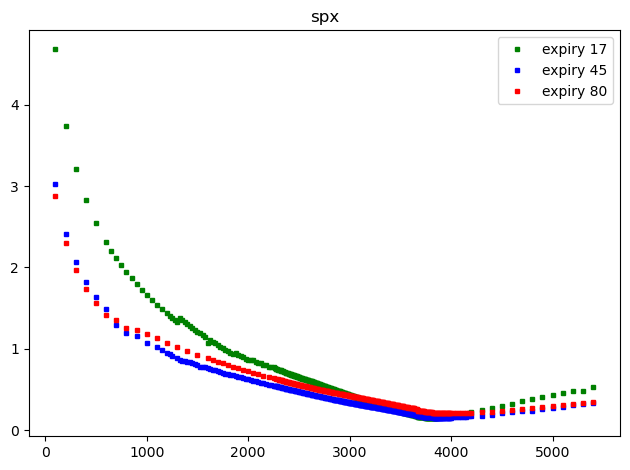

In [113]:
plt.figure(tight_layout=True)
plt.title('spx')
plt.plot(spx_final_df_1['strike'], spx_final_df_1['impliedvol'], 'gs', label='expiry 17',markersize=3)
plt.plot(spx_final_df_2['strike'], spx_final_df_2['impliedvol'], 'bs', label='expiry 45',markersize=3)
plt.plot(spx_final_df_3['strike'], spx_final_df_3['impliedvol'], 'rs', label='expiry 80',markersize=3)
plt.legend()
plt.show()

In [100]:
spy_df_1['vols'] = spy_df_1.apply(lambda x: impliedVolatility(S_y,
                                                  x['strike'],
                                                  r17,
                                                  x['mid'],
                                                  T_1,
                                                  x['payoff']),
                      axis=1)

spy_call_df_1 = spy_df_1[spy_df_1['payoff'] == 'call']
spy_put_df_1 = spy_df_1[spy_df_1['payoff'] == 'put']
impliedvols_4 = []
spy_strikes_1 = spy_put_df_1['strike'].values
payoff = []
for K in spy_strikes_1:    
    if K > S_y:
        impliedvols_4.append(spy_call_df_1[spy_call_df_1['strike'] == K]['vols'].values[0])
        payoff.append('call')
    else:
        impliedvols_4.append(spy_put_df_1[spy_put_df_1['strike'] == K]['vols'].values[0])
        payoff.append('put')

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_final_df_1 = pd.DataFrame({'strike': spy_strikes_1, 'impliedvol': impliedvols_4,'payoff':payoff})



####SABR拟合
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spy_final_df_1['strike'],
                                              spy_final_df_1['impliedvol'],
                                              F17_y,
                                              T_1),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols_4 = []
for K in spy_strikes_1:
    sabrvols_4.append(SABR(F17_y, K, T_1, alpha, beta, rho, nu))

C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3111022155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df_1['vols'] = spy_df_1.apply(lambda x: impliedVolatility(S_y,


Calibrated SABR model parameters: alpha = 0.665, beta = 0.7, rho = -0.412, nu = 5.250


In [57]:
####DD拟合
F1_y = F17_y / np.exp(-r17 * T_1)
ATMprice=np.interp(S_y,spy_df_1['strike'],spy_df_1['mid'])

β0 = 0
β1 = 1
sigma0 = 0
sigma_spy_17 = 1
intialGuess_dd = [0.7]
while abs(β1 - β0)>0.01 or abs(sigma_spy_17 - sigma0) > 0.001:
    print(abs(β1 - β0),abs(sigma_spy_17 - sigma0))
    β0 = β1
    sigma0 = ATM(ATMprice, r17, T_1, F1_y, S_y,β0)
    res_dd = least_squares(lambda x: ddcalibration(x,
                                                   spy_final_df_1['strike'],
                                                   spy_final_df_1['impliedvol'],
                                                   F1_y,
                                                   T_1,
                                                   r17,
                                                   sigma0,
                                                   spy_final_df_1['payoff']),
                           intialGuess_dd,
                           bounds = ([0,1]))
    β1 = res_dd.x[0]
    sigma_spy_17 = ATM(ATMprice, r17, T_1, F1_y, S_y,β1)
    print(f"β0 = {β0}, β1 = {β1} , sigma1 = {sigma1}")

print('Calibrated DD model parameters: beta = %.1f' % (β1))

ddvols_4 = []
for i in range(len(spy_final_df_1)):
    ddvols_4.append(dd(F17_y, spy_final_df_1['strike'][i], T_1, r17,sigma_spy_17,β1, spy_final_df_1['payoff'][i]))

1 1
β0 = 1, β1 = 4.837799689945243e-07 , sigma1 = 0.19409343030040146
0.999999516220031 2.7363038560990205e-05
β0 = 4.837799689945243e-07, β1 = 4.896063398222324e-07 , sigma1 = 0.19409343030040146
Calibrated DD model parameters: beta = 0.0


In [58]:
spy_df_2['vols'] = spy_df_2.apply(lambda x: impliedVolatility(S_y,
                                                  x['strike'],
                                                  r45,
                                                  x['mid'],
                                                  T_2,
                                                  x['payoff']),
                      axis=1)

spy_call_df_2 = spy_df_2[spy_df_2['payoff'] == 'call']
spy_put_df_2 = spy_df_2[spy_df_2['payoff'] == 'put']
impliedvols_5 = []
spy_strikes_2 = spy_put_df_2['strike'].values
payoff = []
for K in spy_strikes_2:    
    if K > S_y:
        impliedvols_5.append(spy_call_df_2[spy_call_df_2['strike'] == K]['vols'].values[0])
        payoff.append('call')
    else:
        impliedvols_5.append(spy_put_df_2[spy_put_df_2['strike'] == K]['vols'].values[0])
        payoff.append('put')

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_final_df_2 = pd.DataFrame({'strike': spy_strikes_2, 'impliedvol': impliedvols_5,'payoff':payoff})



####SABR拟合
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spy_final_df_2['strike'],
                                              spy_final_df_2['impliedvol'],
                                              F45_y,
                                              T_2),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols_5 = []
for K in spy_strikes_2:
    sabrvols_5.append(SABR(F45_y, K, T_2, alpha, beta, rho, nu))

C:\Users\46122\AppData\Local\Temp\ipykernel_23888\544526924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df_2['vols'] = spy_df_2.apply(lambda x: impliedVolatility(S_y,


Calibrated SABR model parameters: alpha = 0.908, beta = 0.7, rho = -0.489, nu = 2.729


In [59]:
F2_y = F45_y / np.exp(-r45 * T_2)
ATMprice=np.interp(S_y,spy_df_2['strike'],spy_df_2['mid'])
β0 = 0
β1 = 1
sigma0 = 0
sigma_spy_45 = 1
intialGuess_dd = [0.7]
while abs(β1 - β0)>0.01 or abs(sigma_spy_45 - sigma0) > 0.05:
    print(abs(β1 - β0),abs(sigma_spy_45 - sigma0))
    β0 = β1
    sigma0 = ATM(ATMprice, r45, T_2, F2_y, S_y,β0)
    res_dd = least_squares(lambda x: ddcalibration(x,
                                                   spy_final_df_2['strike'],
                                                   spy_final_df_2['impliedvol'],
                                                   F2_y,
                                                   T_2,
                                                   r45,
                                                   sigma0,
                                                   spy_final_df_2['payoff']),
                           intialGuess_dd,
                           bounds = ([0,1]))
    β1 = res_dd.x[0]
    sigma_spy_45 = ATM(ATMprice, r45, T_2, F45_y, S_y,β1)
    print(f"β0 = {β0}, β1 = {β1} , sigma_spy_45 = {sigma_spy_45}")
    
print('Calibrated DD model parameters: beta = %.1f' % (β1))

ddvols_5 = []
for i in range(len(spy_final_df_2)):
    ddvols_5.append(dd(F45_y, spy_final_df_2['strike'][i], T_2, r45,sigma_spy_45,β1, spy_final_df_2['payoff'][i]))

1 1
β0 = 1, β1 = 4.9241486177341017e-11 , sigma_spy_45 = 0.17
0.9999999999507585 0.025002169325409024
β0 = 4.9241486177341017e-11, β1 = 3.999107371803631e-06 , sigma_spy_45 = 0.19587081043348997
Calibrated DD model parameters: beta = 0.0


In [60]:
spy_df_3['vols'] = spy_df_3.apply(lambda x: impliedVolatility(S_y,
                                                  x['strike'],
                                                  r80,
                                                  x['mid'],
                                                  T_3,
                                                  x['payoff']),
                      axis=1)

spy_call_df_3 = spy_df_3[spy_df_3['payoff'] == 'call']
spy_put_df_3 = spy_df_3[spy_df_3['payoff'] == 'put']
impliedvols_6 = []
spy_strikes_3 = spy_put_df_3['strike'].values
payoff = []
for K in spy_strikes_3:    
    if K > S_y:
        impliedvols_6.append(spy_call_df_3[spy_call_df_3['strike'] == K]['vols'].values[0])
        payoff.append('call')
    else:
        impliedvols_6.append(spy_put_df_3[spy_put_df_3['strike'] == K]['vols'].values[0])
        payoff.append('put')

# populate "df" with the dataframe containing strikes and market implied volatilities
spy_final_df_3 = pd.DataFrame({'strike': spy_strikes_3, 'impliedvol': impliedvols_6,'payoff':payoff})


####SABR拟合
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              spy_final_df_3['strike'],
                                              spy_final_df_3['impliedvol'],
                                              F80_y,
                                              T_3),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols_6 = []
for K in spy_strikes_3:
    sabrvols_6.append(SABR(F80_y, K, T_3, alpha, beta, rho, nu))

C:\Users\46122\AppData\Local\Temp\ipykernel_23888\1350435348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df_3['vols'] = spy_df_3.apply(lambda x: impliedVolatility(S_y,
C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3266761891.py:13: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.121, beta = 0.7, rho = -0.633, nu = 1.742


In [61]:
F3_y = F80_y / np.exp(-r17 * T_3)
ATMprice=np.interp(S_y,spy_df_3['strike'],spy_df_3['mid'])
intialGuess_dd = [0.7]

β0 = 0
β1 = 1
sigma0 = 0
sigma_spy_80 = 1
while abs(β1 - β0)>0.01 or abs(sigma_spy_80 - sigma0) > 0.01:
    print(abs(β1 - β0),abs(sigma_spy_80 - sigma0))
    β0 = β1
    sigma0 = ATM(ATMprice, r80, T_3, F3_y, S_y,β0)
    res_dd = least_squares(lambda x: ddcalibration(x,
                                                   spy_final_df_3['strike'],
                                                   spy_final_df_3['impliedvol'],
                                                   F3_y,
                                                   T_3,
                                                   r80,
                                                   sigma0,
                                                   spy_final_df_3['payoff']),
                           intialGuess_dd,
                           bounds = ([0,1]))
    β1 = res_dd.x[0]
    sigma_spy_80 = ATM(ATMprice, r80, T_3, F80_y, S_y,β1)
    print(f"β0 = {β0}, β1 = {β1} , sigma_spy_80 = {sigma_spy_80}")
    
print('Calibrated DD model parameters: beta = %.1f' % (β1))

ddvols_6 = []
for i in range(len(spy_final_df_3)):
    ddvols_6.append(dd(F80_y, spy_final_df_3['strike'][i], T_3, r80,sigma_spy_80,β1, spy_final_df_3['payoff'][i]))

1 1
β0 = 1, β1 = 3.519911865668727e-10 , sigma_spy_80 = 0.17046610515269858
0.9999999996480088 0.026797837371332567
β0 = 3.519911865668727e-10, β1 = 4.861938541656072e-12 , sigma_spy_80 = 0.17000363585857
Calibrated DD model parameters: beta = 0.0


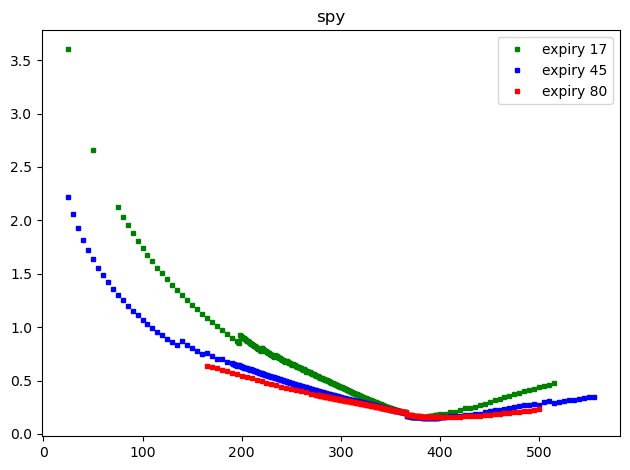

In [62]:
plt.figure(tight_layout=True)
plt.title('spy')
plt.plot(spy_final_df_1['strike'], spy_final_df_1['impliedvol'], 'gs', label='expiry 17',markersize=3)
plt.plot(spy_final_df_2['strike'], spy_final_df_2['impliedvol'], 'bs', label='expiry 45',markersize=3)
plt.plot(spy_final_df_3['strike'], spy_final_df_3['impliedvol'], 'rs', label='expiry 80',markersize=3)
plt.legend()
plt.show()

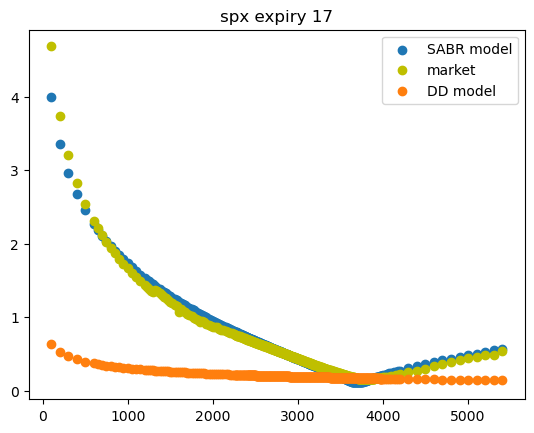

In [63]:
plt.title('spx expiry 17')
plt.scatter(spx_strikes_1,sabrvols_1,label = 'SABR model')
plt.scatter(spx_strikes_1,spx_final_df_1['impliedvol'],color = 'y',label = 'market')
plt.scatter(spx_strikes_1,ddvols_1,label = 'DD model')
plt.legend()
plt.show()

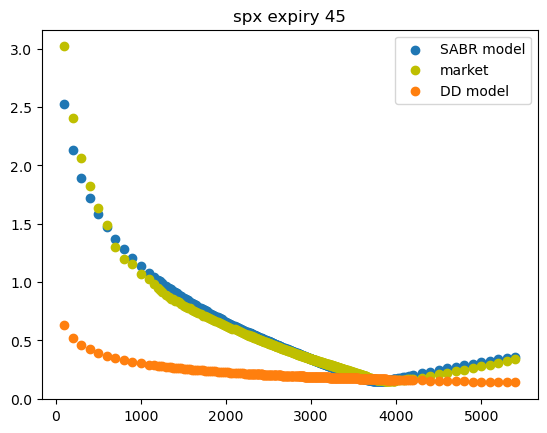

In [64]:
plt.title('spx expiry 45')
plt.scatter(spx_strikes_2,sabrvols_2,label = 'SABR model')
plt.scatter(spx_strikes_2,spx_final_df_2['impliedvol'],color = 'y',label = 'market')
plt.scatter(spx_strikes_2,ddvols_2,label = 'DD model')
plt.legend()
plt.show()

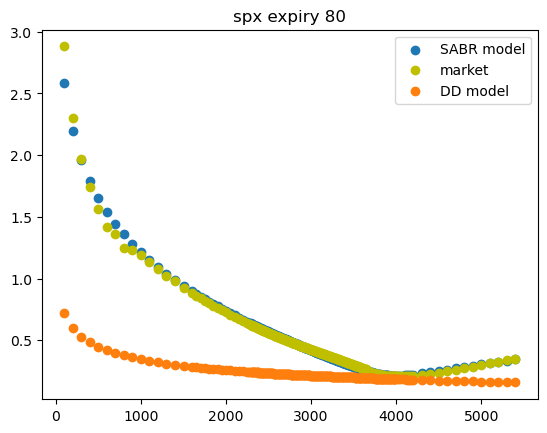

In [65]:
plt.title('spx expiry 80')
plt.scatter(spx_strikes_3,sabrvols_3,label = 'SABR model')
plt.scatter(spx_strikes_3,spx_final_df_3['impliedvol'],color = 'y',label = 'market')
plt.scatter(spx_strikes_3,ddvols_3,label = 'DD model')
plt.legend()
plt.show()

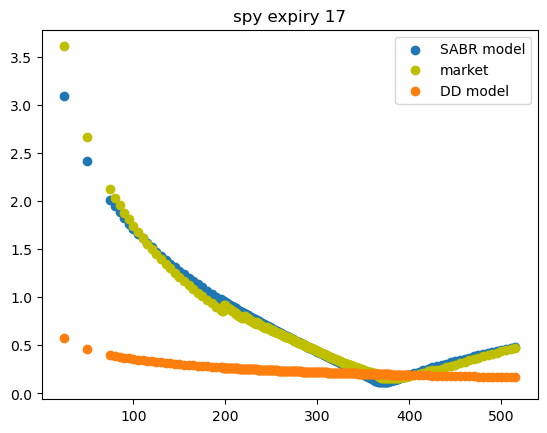

In [66]:
plt.title('spy expiry 17')
plt.scatter(spy_strikes_1,sabrvols_4,label = 'SABR model')
plt.scatter(spy_strikes_1,spy_final_df_1['impliedvol'],color = 'y',label = 'market')
plt.scatter(spy_strikes_1,ddvols_4,label = 'DD model')
plt.legend()
plt.show()

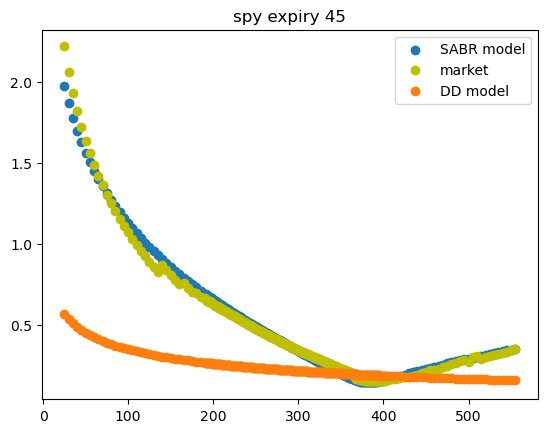

In [67]:
plt.title('spy expiry 45')
plt.scatter(spy_strikes_2,sabrvols_5,label = 'SABR model')
plt.scatter(spy_strikes_2,spy_final_df_2['impliedvol'],color = 'y',label = 'market')
plt.scatter(spy_strikes_2,ddvols_5,label = 'DD model')
plt.legend()
plt.show()

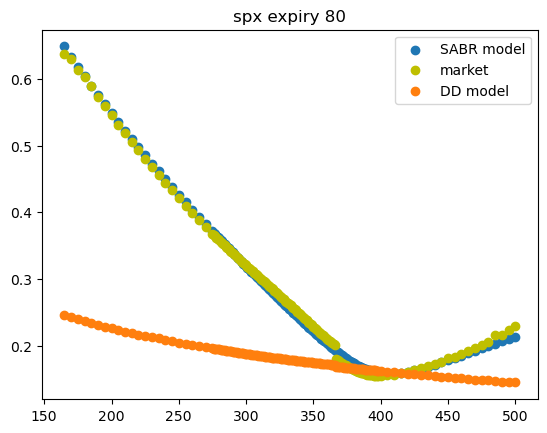

In [68]:
plt.title('spx expiry 80')
plt.scatter(spy_strikes_3,sabrvols_6,label = 'SABR model')
plt.scatter(spy_strikes_3,spy_final_df_3['impliedvol'],color = 'y',label = 'market')
plt.scatter(spy_strikes_3,ddvols_6,label = 'DD model')
plt.legend()
plt.show()

# beta changes in DD model

>spx 

beta

In [69]:
ddvols_spx_17_0=[]
ddvols_spx_17_02=[]
ddvols_spx_17_04=[]
ddvols_spx_17_06=[]
ddvols_spx_17_08=[]
ddvols_spx_17_1=[]
for i in range(len(spx_final_df_1)):
    ddvols_spx_17_0.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,sigma1,1e-12, spx_final_df_1['payoff'][i]))
    ddvols_spx_17_02.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,sigma1,0.2, spx_final_df_1['payoff'][i]))
    ddvols_spx_17_04.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,sigma1,0.4, spx_final_df_1['payoff'][i]))
    ddvols_spx_17_06.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,sigma1,0.6, spx_final_df_1['payoff'][i]))
    ddvols_spx_17_08.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,sigma1,0.8, spx_final_df_1['payoff'][i]))
    ddvols_spx_17_1.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,sigma1,1, spx_final_df_1['payoff'][i]))

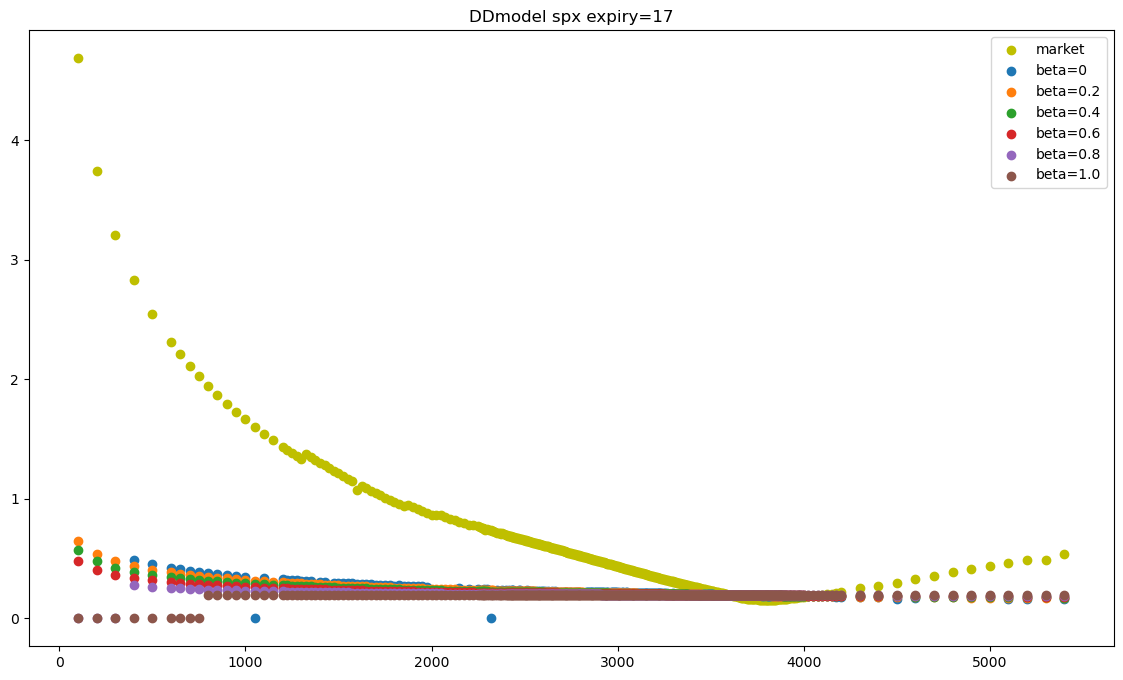

In [70]:
plt.figure(figsize=(14,8))
plt.title('DDmodel spx expiry=17')
plt.scatter(spx_strikes_1,spx_final_df_1['impliedvol'],color = 'y',label = 'market')
plt.scatter(spx_strikes_1,ddvols_spx_17_0,label = 'beta=0')
plt.scatter(spx_strikes_1,ddvols_spx_17_02,label = 'beta=0.2')
plt.scatter(spx_strikes_1,ddvols_spx_17_04,label = 'beta=0.4')
plt.scatter(spx_strikes_1,ddvols_spx_17_06,label = 'beta=0.6')
plt.scatter(spx_strikes_1,ddvols_spx_17_08,label = 'beta=0.8')
plt.scatter(spx_strikes_1,ddvols_spx_17_1,label = 'beta=1.0')
plt.legend()
plt.show()

In [71]:
ddvols_spx_45_0=[]
ddvols_spx_45_02=[]
ddvols_spx_45_04=[]
ddvols_spx_45_06=[]
ddvols_spx_45_08=[]
ddvols_spx_45_2=[]
for i in range(len(spx_final_df_2)):
    ddvols_spx_45_0.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,sigma_spx_45,1e-12, spx_final_df_2['payoff'][i]))
    ddvols_spx_45_02.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,sigma_spx_45,0.2, spx_final_df_2['payoff'][i]))
    ddvols_spx_45_04.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,sigma_spx_45,0.4, spx_final_df_2['payoff'][i]))
    ddvols_spx_45_06.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,sigma_spx_45,0.6, spx_final_df_2['payoff'][i]))
    ddvols_spx_45_08.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,sigma_spx_45,0.8, spx_final_df_2['payoff'][i]))
    ddvols_spx_45_2.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,sigma_spx_45,1, spx_final_df_2['payoff'][i]))

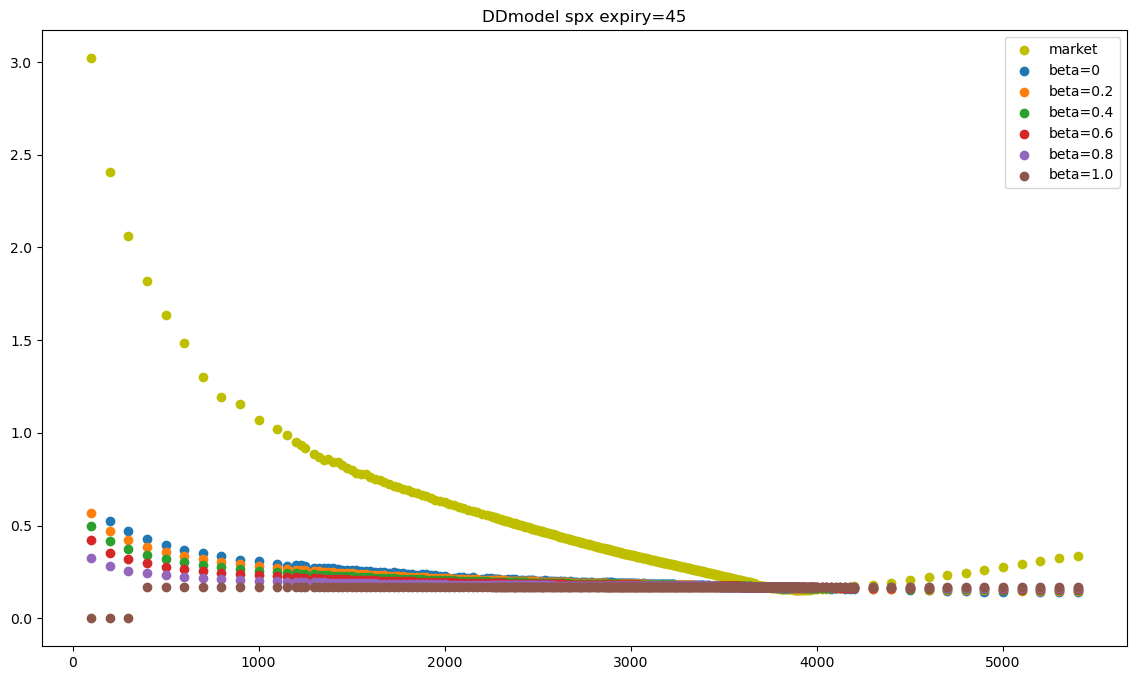

In [72]:
plt.figure(figsize=(14,8))
plt.title('DDmodel spx expiry=45')
plt.scatter(spx_strikes_2,spx_final_df_2['impliedvol'],color = 'y',label = 'market')
plt.scatter(spx_strikes_2,ddvols_spx_45_0,label = 'beta=0')
plt.scatter(spx_strikes_2,ddvols_spx_45_02,label = 'beta=0.2')
plt.scatter(spx_strikes_2,ddvols_spx_45_04,label = 'beta=0.4')
plt.scatter(spx_strikes_2,ddvols_spx_45_06,label = 'beta=0.6')
plt.scatter(spx_strikes_2,ddvols_spx_45_08,label = 'beta=0.8')
plt.scatter(spx_strikes_2,ddvols_spx_45_1,label = 'beta=1.0')
plt.legend()
plt.show()

In [73]:
ddvols_spx_80_0=[]
ddvols_spx_80_02=[]
ddvols_spx_80_04=[]
ddvols_spx_80_06=[]
ddvols_spx_80_08=[]
ddvols_spx_80_1=[]
for i in range(len(spx_final_df_3)):
    ddvols_spx_80_0.append(
        dd(F80_x, spx_final_df_3['strike'][i], T_3, r80,sigma_spx_80,1e-12, spx_final_df_3['payoff'][i]))
    ddvols_spx_80_02.append(
        dd(F80_x, spx_final_df_3['strike'][i], T_3, r80,sigma_spx_80,0.2, spx_final_df_3['payoff'][i]))
    ddvols_spx_80_04.append(
        dd(F80_x, spx_final_df_3['strike'][i], T_3, r80,sigma_spx_80,0.4, spx_final_df_3['payoff'][i]))
    ddvols_spx_80_06.append(
        dd(F80_x, spx_final_df_3['strike'][i], T_3, r80,sigma_spx_80,0.6, spx_final_df_3['payoff'][i]))
    ddvols_spx_80_08.append(
        dd(F80_x, spx_final_df_3['strike'][i], T_3, r80,sigma_spx_80,0.8, spx_final_df_3['payoff'][i]))
    ddvols_spx_80_1.append(
        dd(F80_x, spx_final_df_3['strike'][i], T_3, r80,sigma_spx_80,1, spx_final_df_3['payoff'][i]))

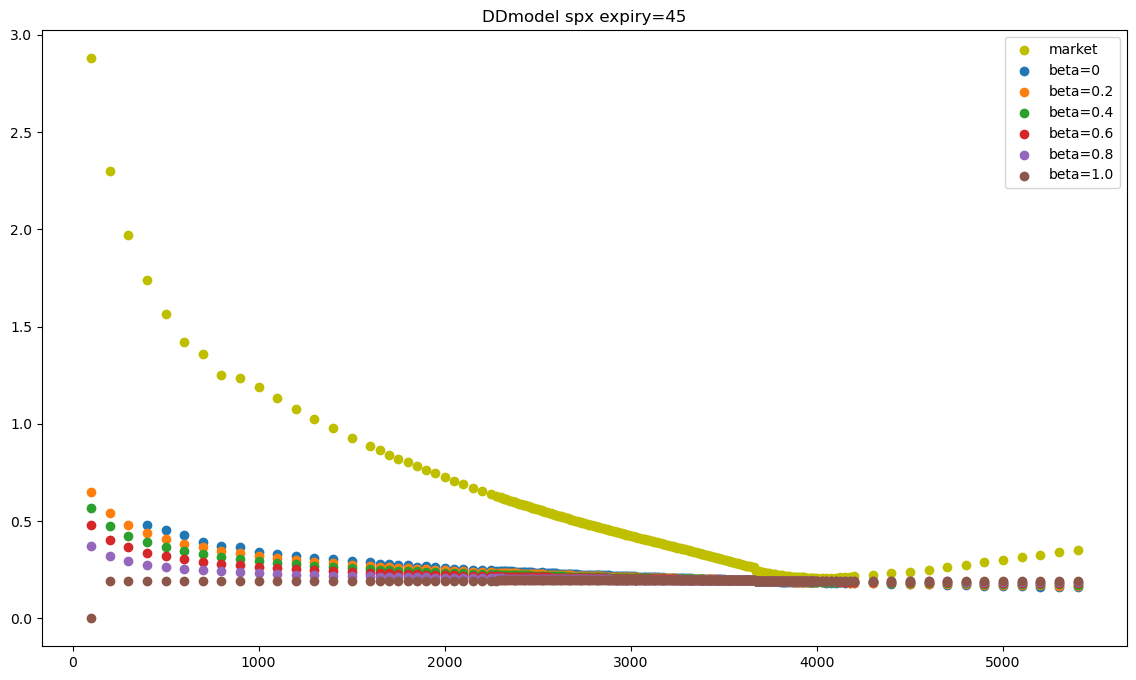

In [74]:
plt.figure(figsize=(14,8))
plt.title('DDmodel spx expiry=45')
plt.scatter(spx_strikes_3,spx_final_df_3['impliedvol'],color = 'y',label = 'market')
plt.scatter(spx_strikes_3,ddvols_spx_80_0,label = 'beta=0')
plt.scatter(spx_strikes_3,ddvols_spx_80_02,label = 'beta=0.2')
plt.scatter(spx_strikes_3,ddvols_spx_80_04,label = 'beta=0.4')
plt.scatter(spx_strikes_3,ddvols_spx_80_06,label = 'beta=0.6')
plt.scatter(spx_strikes_3,ddvols_spx_80_08,label = 'beta=0.8')
plt.scatter(spx_strikes_3,ddvols_spx_80_1,label = 'beta=1.0')
plt.legend()
plt.show()

sigma

In [94]:
ddvols_spx_17_sigma1=[]
ddvols_spx_17_sigma2=[]
ddvols_spx_17_sigma3=[]
for i in range(len(spx_final_df_1)):
    ddvols_spx_17_sigma1.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,0.3,1.913393032161793e-07, spx_final_df_1['payoff'][i]))
    ddvols_spx_17_sigma2.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,0.5,1.913393032161793e-07, spx_final_df_1['payoff'][i]))
    ddvols_spx_17_sigma3.append(
        dd(F17_x, spx_final_df_1['strike'][i], T_1, r17,0.7,1.913393032161793e-07, spx_final_df_1['payoff'][i]))

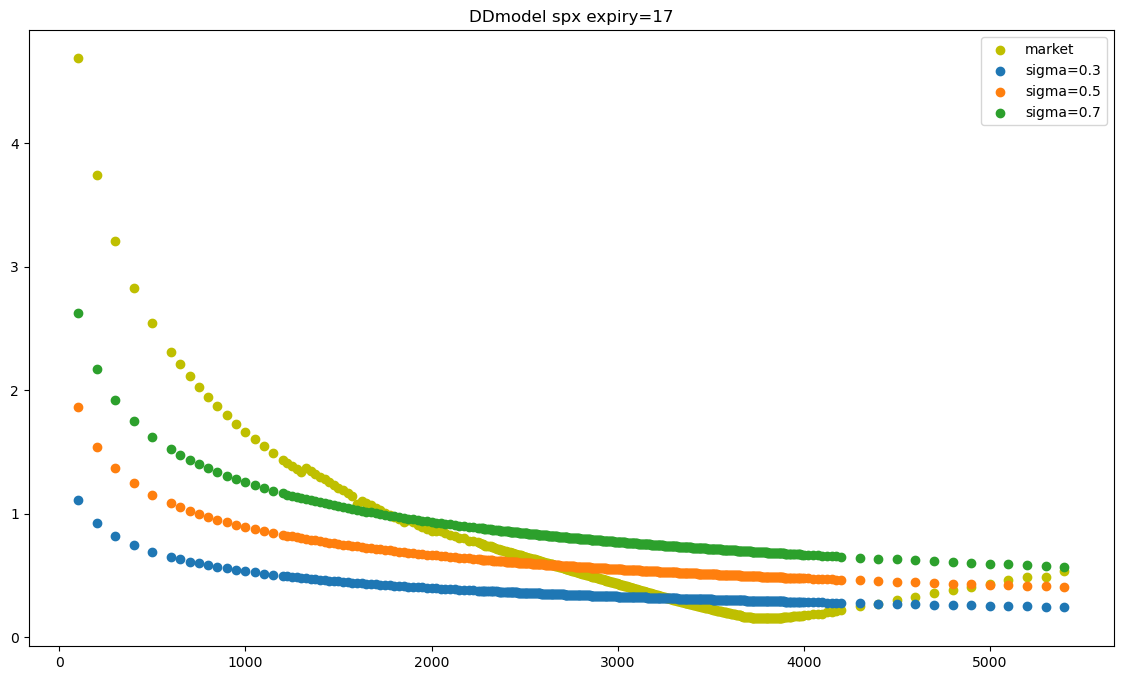

In [95]:
plt.figure(figsize=(14,8))
plt.title('DDmodel spx expiry=17')
plt.scatter(spx_strikes_1,spx_final_df_1['impliedvol'],color = 'y',label = 'market')
plt.scatter(spx_strikes_1,ddvols_spx_17_sigma1,label = 'sigma=0.3')
plt.scatter(spx_strikes_1,ddvols_spx_17_sigma2,label = 'sigma=0.5')
plt.scatter(spx_strikes_1,ddvols_spx_17_sigma3,label = 'sigma=0.7')
plt.legend()
plt.show()

In [97]:
ddvols_spx_45_sigma1=[]
ddvols_spx_45_sigma2=[]
ddvols_spx_45_sigma3=[]
for i in range(len(spx_final_df_2)):
    ddvols_spx_45_sigma1.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,0.3,1.8103626884588779e-10, spx_final_df_2['payoff'][i]))
    ddvols_spx_45_sigma2.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,0.5,1.8103626884588779e-10, spx_final_df_2['payoff'][i]))
    ddvols_spx_45_sigma3.append(
        dd(F45_x, spx_final_df_2['strike'][i], T_2, r45,0.7,1.8103626884588779e-10, spx_final_df_2['payoff'][i]))

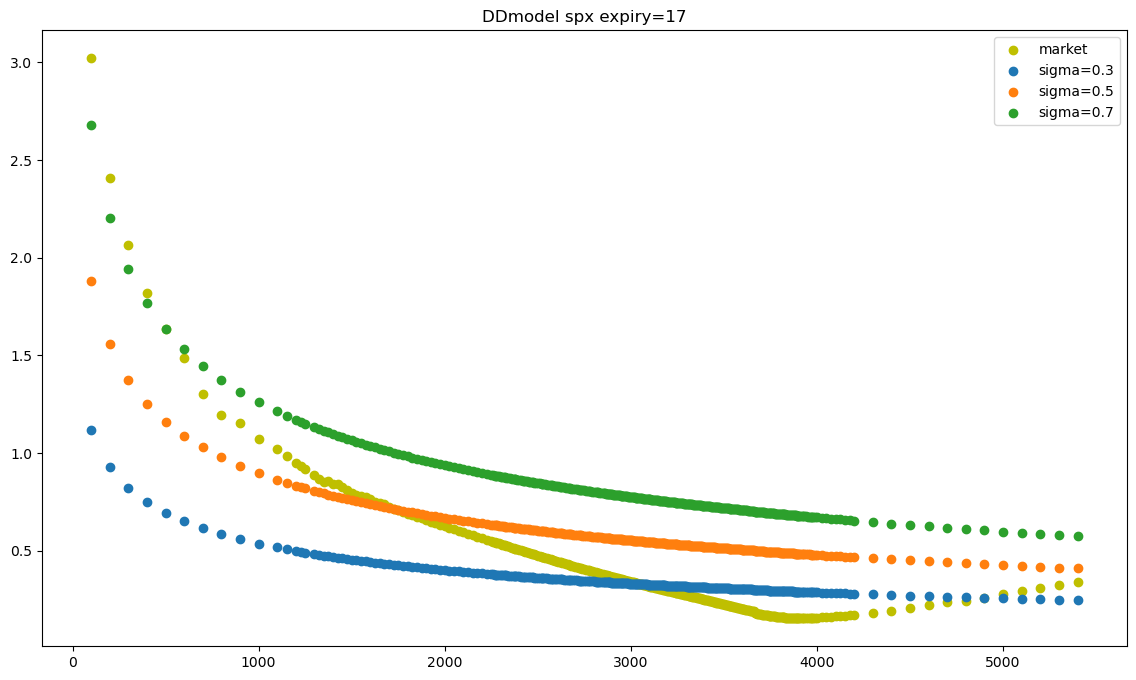

In [98]:
plt.figure(figsize=(14,8))
plt.title('DDmodel spx expiry=17')
plt.scatter(spx_strikes_2,spx_final_df_2['impliedvol'],color = 'y',label = 'market')
plt.scatter(spx_strikes_2,ddvols_spx_45_sigma1,label = 'sigma=0.3')
plt.scatter(spx_strikes_2,ddvols_spx_45_sigma2,label = 'sigma=0.5')
plt.scatter(spx_strikes_2,ddvols_spx_45_sigma3,label = 'sigma=0.7')
plt.legend()
plt.show()

>spy

In [77]:
ddvols_spy_17_0=[]
ddvols_spy_17_02=[]
ddvols_spy_17_04=[]
ddvols_spy_17_06=[]
ddvols_spy_17_08=[]
ddvols_spy_17_1=[]
for i in range(len(spy_final_df_1)):
    ddvols_spy_17_0.append(
        dd(F17_y, spy_final_df_1['strike'][i], T_1, r17,sigma_spy_17,1e-12, spy_final_df_1['payoff'][i]))
    ddvols_spy_17_02.append(
        dd(F17_y, spy_final_df_1['strike'][i], T_1, r17,sigma_spy_17,0.2, spy_final_df_1['payoff'][i]))
    ddvols_spy_17_04.append(
        dd(F17_y, spy_final_df_1['strike'][i], T_1, r17,sigma_spy_17,0.4, spy_final_df_1['payoff'][i]))
    ddvols_spy_17_06.append(
        dd(F17_y, spy_final_df_1['strike'][i], T_1, r17,sigma_spy_17,0.6, spy_final_df_1['payoff'][i]))
    ddvols_spy_17_08.append(
        dd(F17_y, spy_final_df_1['strike'][i], T_1, r17,sigma_spy_17,0.8, spy_final_df_1['payoff'][i]))
    ddvols_spy_17_1.append(
        dd(F17_y, spy_final_df_1['strike'][i], T_1, r17,sigma_spy_17,1, spy_final_df_1['payoff'][i]))

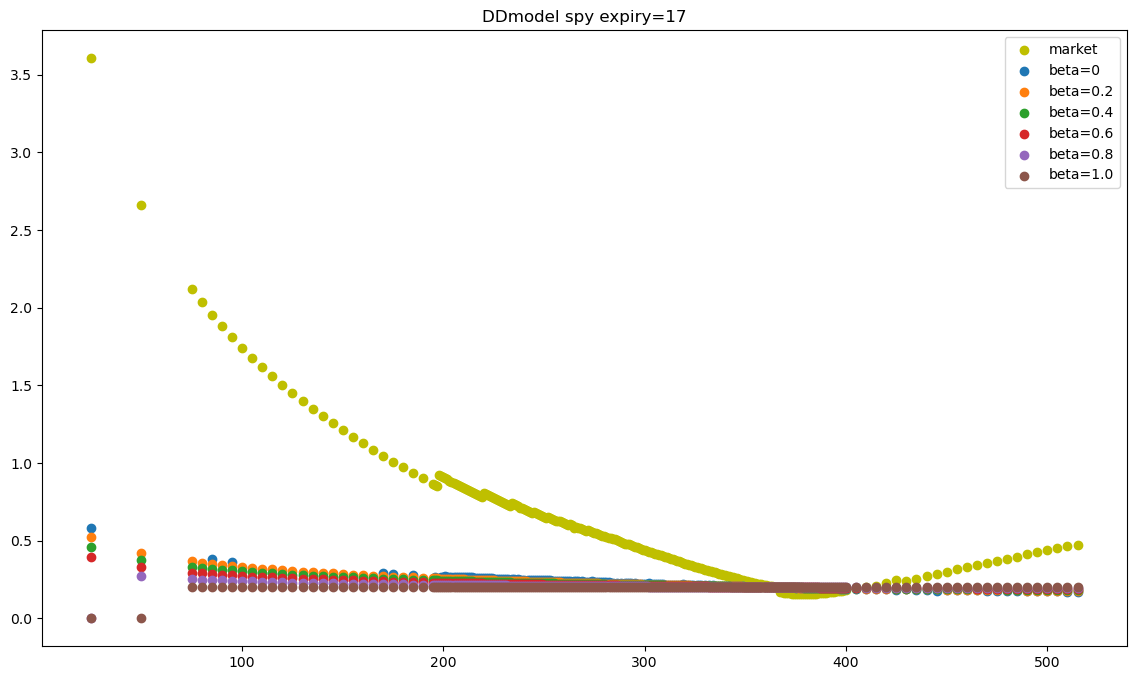

In [78]:
plt.figure(figsize=(14,8))
plt.title('DDmodel spy expiry=17')
plt.scatter(spy_strikes_1,spy_final_df_1['impliedvol'],color = 'y',label = 'market')
plt.scatter(spy_strikes_1,ddvols_spy_17_0,label = 'beta=0')
plt.scatter(spy_strikes_1,ddvols_spy_17_02,label = 'beta=0.2')
plt.scatter(spy_strikes_1,ddvols_spy_17_04,label = 'beta=0.4')
plt.scatter(spy_strikes_1,ddvols_spy_17_06,label = 'beta=0.6')
plt.scatter(spy_strikes_1,ddvols_spy_17_08,label = 'beta=0.8')
plt.scatter(spy_strikes_1,ddvols_spy_17_1,label = 'beta=1.0')
plt.legend()
plt.show()

In [82]:
ddvols_spy_45_0=[]
ddvols_spy_45_02=[]
ddvols_spy_45_04=[]
ddvols_spy_45_06=[]
ddvols_spy_45_08=[]
ddvols_spy_45_1=[]
for i in range(len(spy_final_df_2)):
    ddvols_spy_45_0.append(
        dd(F45_y, spy_final_df_2['strike'][i], T_2, r45,sigma_spy_45,1e-12, spy_final_df_2['payoff'][i]))
    ddvols_spy_45_02.append(
        dd(F45_y, spy_final_df_2['strike'][i], T_2, r45,sigma_spy_45,0.2, spy_final_df_2['payoff'][i]))
    ddvols_spy_45_04.append(
        dd(F45_y, spy_final_df_2['strike'][i], T_2, r45,sigma_spy_45,0.4, spy_final_df_2['payoff'][i]))
    ddvols_spy_45_06.append(
        dd(F45_y, spy_final_df_2['strike'][i], T_2, r45,sigma_spy_45,0.6, spy_final_df_2['payoff'][i]))
    ddvols_spy_45_08.append(
        dd(F45_y, spy_final_df_2['strike'][i], T_2, r45,sigma_spy_45,0.8, spy_final_df_2['payoff'][i]))
    ddvols_spy_45_1.append(
        dd(F45_y, spy_final_df_2['strike'][i], T_2, r45,sigma_spy_45,1, spy_final_df_2['payoff'][i]))

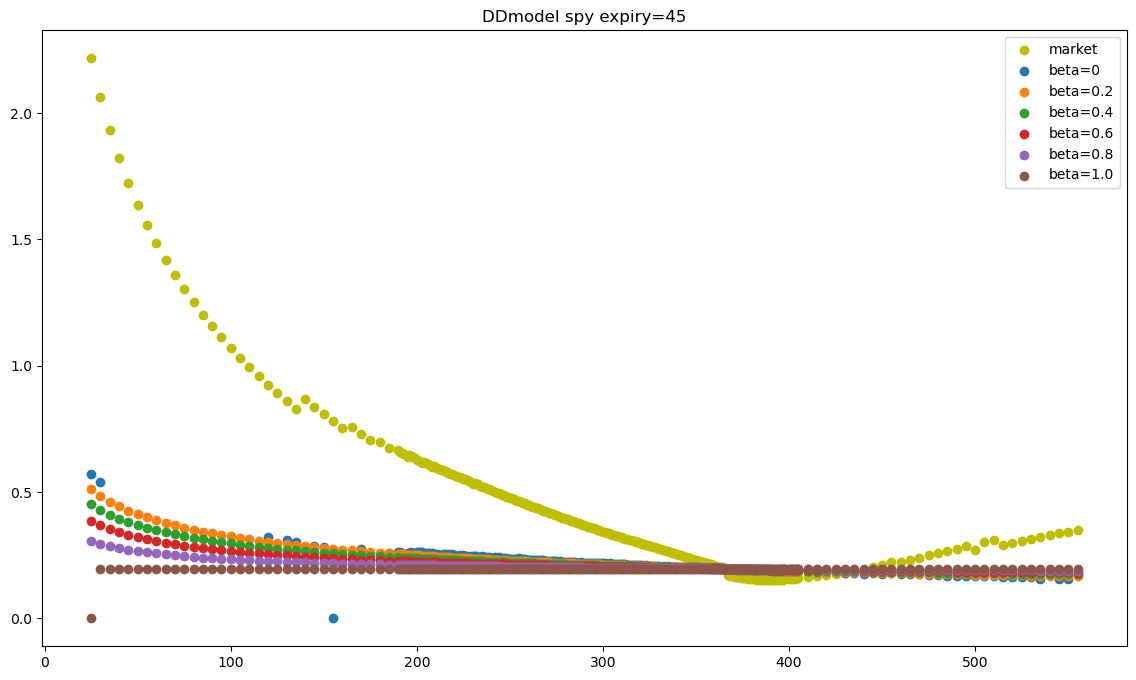

In [83]:
plt.figure(figsize=(14,8))
plt.title('DDmodel spy expiry=45')
plt.scatter(spy_strikes_2,spy_final_df_2['impliedvol'],color = 'y',label = 'market')
plt.scatter(spy_strikes_2,ddvols_spy_45_0,label = 'beta=0')
plt.scatter(spy_strikes_2,ddvols_spy_45_02,label = 'beta=0.2')
plt.scatter(spy_strikes_2,ddvols_spy_45_04,label = 'beta=0.4')
plt.scatter(spy_strikes_2,ddvols_spy_45_06,label = 'beta=0.6')
plt.scatter(spy_strikes_2,ddvols_spy_45_08,label = 'beta=0.8')
plt.scatter(spy_strikes_2,ddvols_spy_45_1,label = 'beta=1.0')
plt.legend()
plt.show()

In [84]:
ddvols_spy_80_0=[]
ddvols_spy_80_02=[]
ddvols_spy_80_04=[]
ddvols_spy_80_06=[]
ddvols_spy_80_08=[]
ddvols_spy_80_1=[]
for i in range(len(spy_final_df_3)):
    ddvols_spy_80_0.append(
        dd(F80_y, spy_final_df_3['strike'][i], T_3, r80,sigma_spy_80,1e-12, spy_final_df_3['payoff'][i]))
    ddvols_spy_80_02.append(
        dd(F80_y, spy_final_df_3['strike'][i], T_3, r80,sigma_spy_80,0.2, spy_final_df_3['payoff'][i]))
    ddvols_spy_80_04.append(
        dd(F80_y, spy_final_df_3['strike'][i], T_3, r80,sigma_spy_80,0.4, spy_final_df_3['payoff'][i]))
    ddvols_spy_80_06.append(
        dd(F80_y, spy_final_df_3['strike'][i], T_3, r80,sigma_spy_80,0.6, spy_final_df_3['payoff'][i]))
    ddvols_spy_80_08.append(
        dd(F80_y, spy_final_df_3['strike'][i], T_3, r80,sigma_spy_80,0.8, spy_final_df_3['payoff'][i]))
    ddvols_spy_80_1.append(
        dd(F80_y, spy_final_df_3['strike'][i], T_3, r80,sigma_spy_80,1, spy_final_df_3['payoff'][i]))

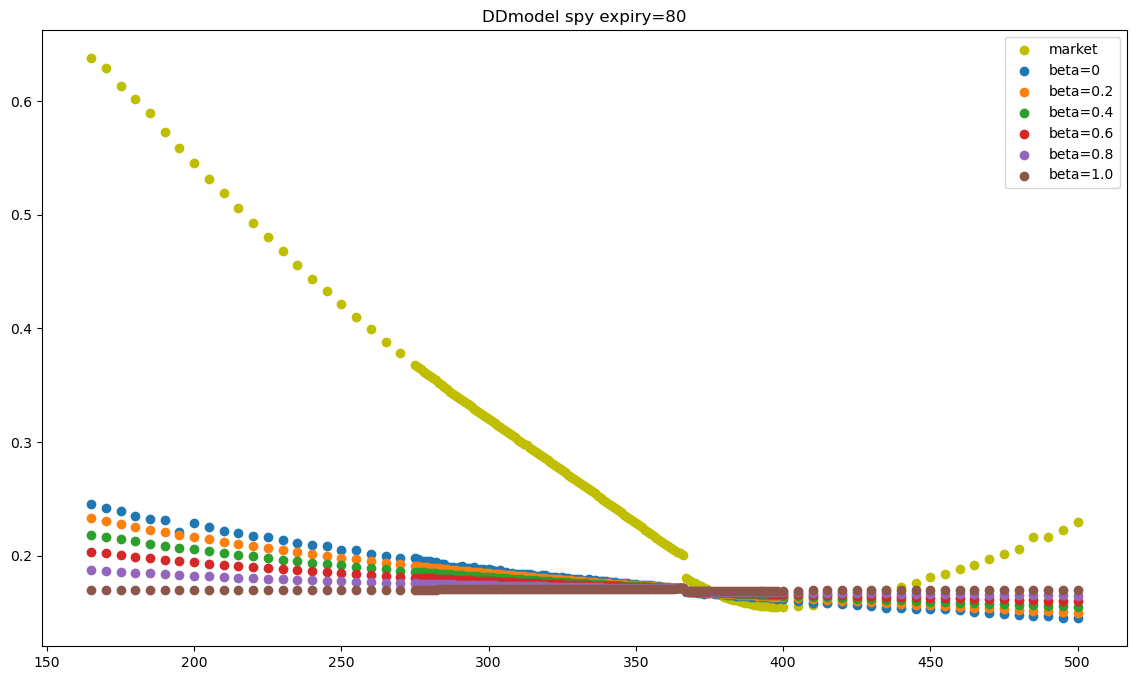

In [86]:
plt.figure(figsize=(14,8))
plt.title('DDmodel spy expiry=80')
plt.scatter(spy_strikes_3,spy_final_df_3['impliedvol'],color = 'y',label = 'market')
plt.scatter(spy_strikes_3,ddvols_spy_80_0,label = 'beta=0')
plt.scatter(spy_strikes_3,ddvols_spy_80_02,label = 'beta=0.2')
plt.scatter(spy_strikes_3,ddvols_spy_80_04,label = 'beta=0.4')
plt.scatter(spy_strikes_3,ddvols_spy_80_06,label = 'beta=0.6')
plt.scatter(spy_strikes_3,ddvols_spy_80_08,label = 'beta=0.8')
plt.scatter(spy_strikes_3,ddvols_spy_80_1,label = 'beta=1.0')
plt.legend()
plt.show()

# SABR nu

In [88]:
sabrvols_nu_05 = []
sabrvols_nu_0 = []
sabrvols_nu_n05 = []

for K in spx_strikes_1:
    sabrvols_nu_05.append(SABR(F17_x, K, T_1, alpha, beta, rho, 0.5))
    sabrvols_nu_0.append(SABR(F17_x, K, T_1, alpha, beta, rho, 0))
    sabrvols_nu_n05.append(SABR(F17_x, K, T_1, alpha, beta, rho, -0.5))    

C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3266761891.py:21: RuntimeWarning: invalid value encountered in scalar divide
  sabrsigma = numer/denom


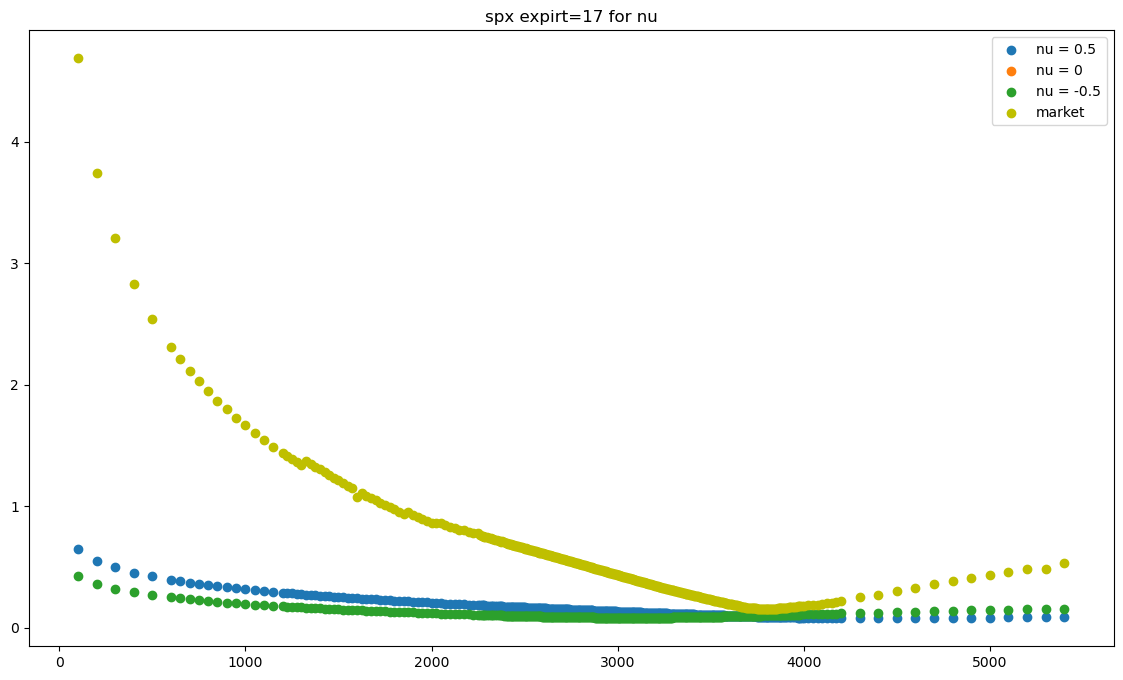

In [99]:
plt.figure(figsize=(14,8))
plt.title('spx expirt=17 for nu')
plt.scatter(spx_strikes_1,sabrvols_nu_05,label = 'nu = 0.5')
plt.scatter(spx_strikes_1,sabrvols_nu_0,label = 'nu = 0')
plt.scatter(spx_strikes_1,sabrvols_nu_n05,label = 'nu = -0.5')
plt.scatter(spx_strikes_1,spx_final_df_1['impliedvol'],color = 'y',label = 'market')
plt.legend()
plt.show()

# SABR alpha

In [103]:
sabrvols_alpha_3 = []
sabrvols_alpha_2 = []
sabrvols_alpha_1 = []

for K in spx_strikes_1:
    sabrvols_alpha_3.append(SABR(F17_x, K, T_1, 3, beta, rho, nu))
    sabrvols_alpha_2.append(SABR(F17_x, K, T_1, 2, beta, rho, nu))
    sabrvols_alpha_1.append(SABR(F17_x, K, T_1, 1, beta, rho, nu))   

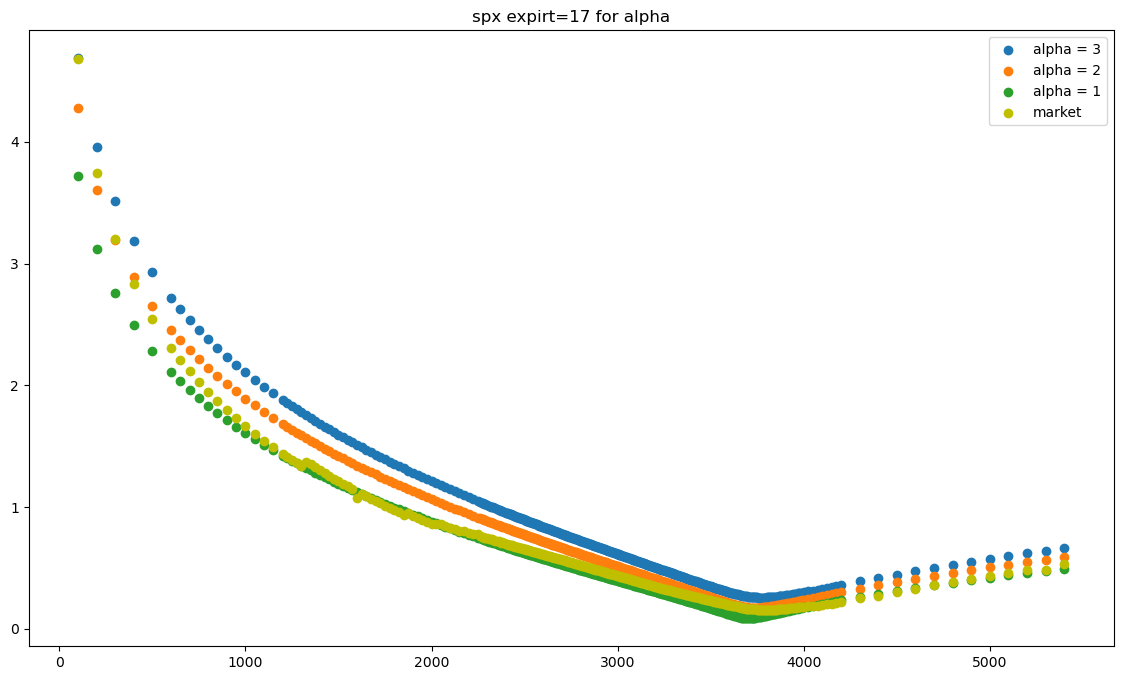

In [105]:
plt.figure(figsize=(14,8))
plt.title('spx expirt=17 for alpha')
plt.scatter(spx_strikes_1,sabrvols_alpha_3,label = 'alpha = 3')
plt.scatter(spx_strikes_1,sabrvols_alpha_2,label = 'alpha = 2')
plt.scatter(spx_strikes_1,sabrvols_alpha_1,label = 'alpha = 1')
plt.scatter(spx_strikes_1,spx_final_df_1['impliedvol'],color = 'y',label = 'market')
plt.legend()
plt.show()

# SABR rho

In [110]:
sabrvols_rho_05 = []
sabrvols_rho_0 = []
sabrvols_rho_n05 = []

for K in spx_strikes_1:
    sabrvols_rho_05.append(SABR(F17_x, K, T_1, 0.5, beta, rho, nu))
    sabrvols_rho_0.append(SABR(F17_x, K, T_1, 1e-12, beta, rho, nu))
    sabrvols_rho_n05.append(SABR(F17_x, K, T_1, -0.5, beta, rho, nu))   

C:\Users\46122\AppData\Local\Temp\ipykernel_23888\3266761891.py:13: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


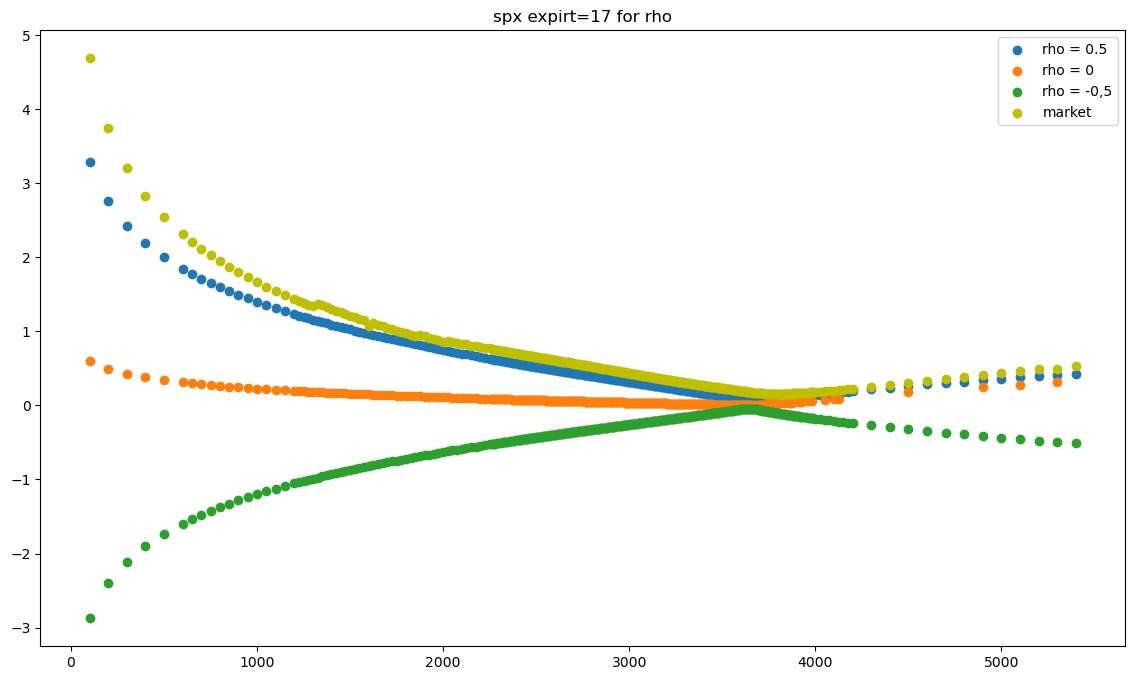

In [111]:
plt.figure(figsize=(14,8))
plt.title('spx expirt=17 for rho')
plt.scatter(spx_strikes_1,sabrvols_rho_05,label = 'rho = 0.5')
plt.scatter(spx_strikes_1,sabrvols_rho_0,label = 'rho = 0')
plt.scatter(spx_strikes_1,sabrvols_rho_n05,label = 'rho = -0,5')
plt.scatter(spx_strikes_1,spx_final_df_1['impliedvol'],color = 'y',label = 'market')
plt.legend()
plt.show()